In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# from warnings import simplefilter
# simplefilter("ignore")  # ignore warnings to clean up output cells

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


https://www.kaggle.com/competitions/rossmann-store-sales

In [2]:
!pip install scikit-multiflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.4 MB/s eta 0:00:0000:0100:010m


In [3]:
!pip install creme


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.4 MB/s eta 0:00:0000:0100:010m
  Preparing metadata (setup.py) ... done
  Created wheel for mmh3: filename=mmh3-2.5.1-cp37-cp37m-linux_x86_64.whl size=49222 sha256=b0da268aba8ee39c0c765c5ab0142af1fd67aba8d088f1181f86af400852e022
  Stored in directory: /root/.cache/pip/wheels/ae/45/25/90e097a519143b2dca74cd93a056894a965f27908103e01799
Successfully built mmh3
  Attempting uninstall: mmh3
    Found existing installation: mmh3 3.0.0
    Uninstalling mmh3-3.0.0:
      Successfully uninstalled mmh3-3.0.0


In [4]:
!pip install river

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 3.7 MB/s eta 0:00:00a 0:00:010m


In [5]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.3 MB/s eta 0:00:0000:0100:010m


## 1. Importing

In [6]:
import river
import creme
import skmultiflow

In [7]:
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.tsa.stattools import adfuller

# from datetime import datetime
mpl.rcParams['figure.figsize'] = (14, 8)
mpl.rcParams['axes.grid'] = False

In [8]:
import xgboost as xgb
# from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split as ttsplit
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.base import clone
import copy


In [9]:
# Load data
df_store = pd.read_csv("/kaggle/input/rossmann-store-sales/store.csv")
df_train = pd.read_csv("/kaggle/input/rossmann-store-sales/train.csv", parse_dates=["Date"])
df_test = pd.read_csv("/kaggle/input/rossmann-store-sales/test.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [11]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [12]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [13]:
print(f"Number of stores: {df_train.Store.nunique()}")

Number of stores: 1115


In [14]:
# df_test.head()

In [15]:
# Taking only 1 store to work on: 

df_store_1 = df_train.query("Store == 1")
df_store_1

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1115,1,4,2015-07-30,5020,546,1,1,0,1
2230,1,3,2015-07-29,4782,523,1,1,0,1
3345,1,2,2015-07-28,5011,560,1,1,0,1
4460,1,1,2015-07-27,6102,612,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1011635,1,6,2013-01-05,4997,635,1,0,0,1
1012750,1,5,2013-01-04,4486,619,1,0,0,1
1013865,1,4,2013-01-03,4327,578,1,0,0,1
1014980,1,3,2013-01-02,5530,668,1,0,0,1


In [16]:
# Original version of dataframe
df_store_1_nonIdx = df_store_1.copy()

In [17]:
# Useful for many cases
df_store_1 = df_store_1.set_index('Date')

In [18]:
df_store_1.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-30,1,4,5020,546,1,1,0,1
2015-07-29,1,3,4782,523,1,1,0,1
2015-07-28,1,2,5011,560,1,1,0,1
2015-07-27,1,1,6102,612,1,1,0,1


In [19]:
# Increasing order by Date col
df_store_1.sort_values(by="Date", inplace=True)

In [20]:
df_store_1.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1
2013-01-02,1,3,5530,668,1,0,0,1
2013-01-03,1,4,4327,578,1,0,0,1
2013-01-04,1,5,4486,619,1,0,0,1
2013-01-05,1,6,4997,635,1,0,0,1


In [21]:
# Checking for Nulls
df_store_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Store          942 non-null    int64 
 1   DayOfWeek      942 non-null    int64 
 2   Sales          942 non-null    int64 
 3   Customers      942 non-null    int64 
 4   Open           942 non-null    int64 
 5   Promo          942 non-null    int64 
 6   StateHoliday   942 non-null    object
 7   SchoolHoliday  942 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 66.2+ KB


In [22]:
# Basic Distribution of data
df_store_1.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,942.0,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000
mean,1.0,3.997877,3945.704883,467.646497,0.829087,0.382166,0.204883
std,0.0,1.998404,2015.417840,228.930850,0.376633,0.486175,0.403831
min,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,2.000000,3588.250000,463.000000,1.000000,0.000000,0.000000
50%,1.0,4.000000,4373.500000,529.000000,1.000000,0.000000,0.000000
75%,1.0,6.000000,5220.000000,598.750000,1.000000,1.000000,0.000000
max,1.0,7.000000,9528.000000,1130.000000,1.000000,1.000000,1.000000


## 2. Visualize

<AxesSubplot:xlabel='Date'>

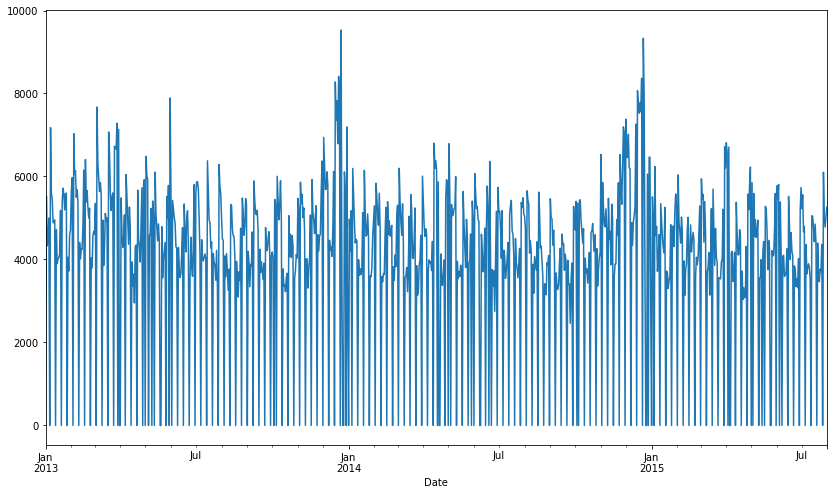

In [23]:
# Plot : X -> Date, Y -> Sales

sales = df_store_1["Sales"]
sales.plot()

<AxesSubplot:xlabel='Date'>

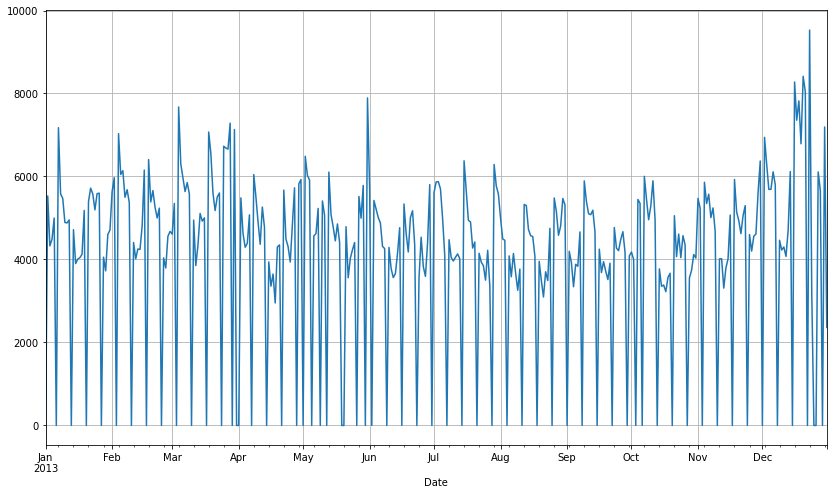

In [24]:
# Subsetting only 1 year of Sales
sales['2013'].plot(grid=True)

<AxesSubplot:xlabel='Date'>

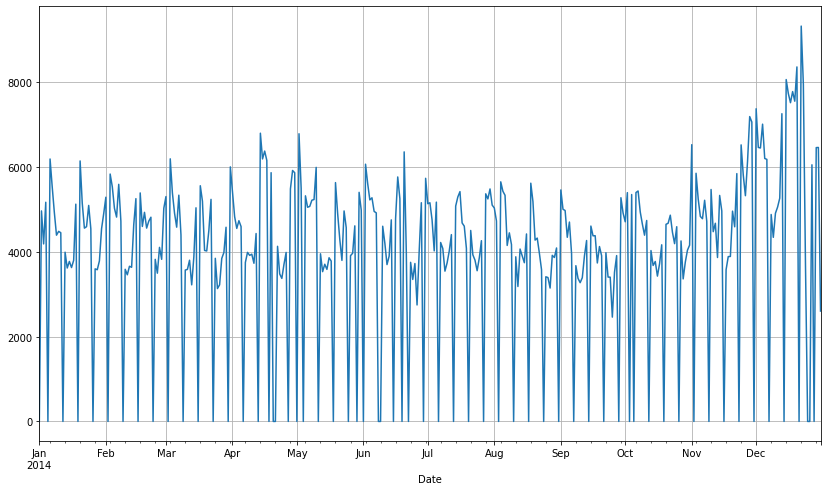

In [25]:
# Subsetting only 1 year of Sales

sales['2014'].plot(grid=True)

In [26]:
# Interactive Plot with Plotly Express

import plotly.express as px

fig = px.line(df_store_1_nonIdx, x='Date', y='Sales', title='Store 1: Sales with Slider')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

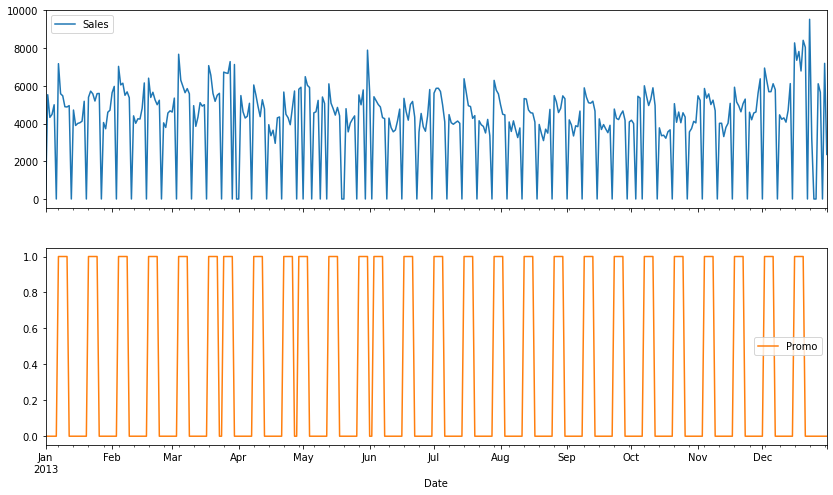

In [27]:
# Multivariate Plot of a Year data: Sales and Promo

df_2013 = df_store_1["2013"]
prom_df_2013 = df_2013[["Sales", "Promo"]]
prom_df_2013.plot(subplots=True)


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

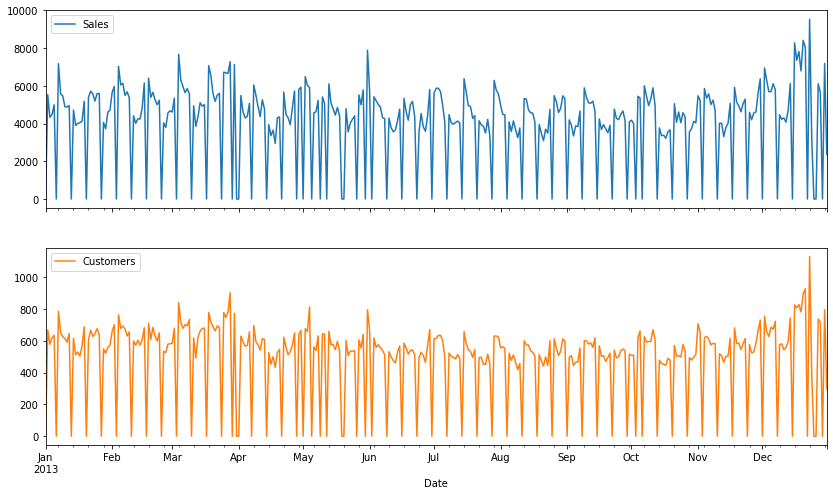

In [28]:
# Multivariate Plot of a Year data: Sales and Customers

customer_df_2013 = df_2013[["Sales", "Customers"]]
customer_df_2013.plot(subplots=True)

<AxesSubplot:xlabel='Date'>

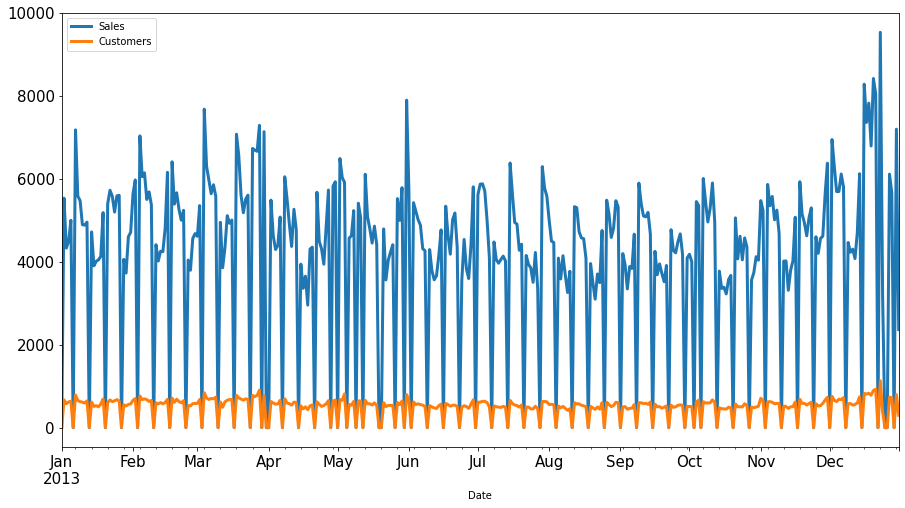

In [29]:
#  Multivariate Plot Overlay : Sales and Customer

customer_df_2013 = df_2013[["Sales", "Customers"]]
customer_df_2013.plot(figsize=(15,8), linewidth=3, fontsize=15)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



<AxesSubplot:xlabel='Date'>

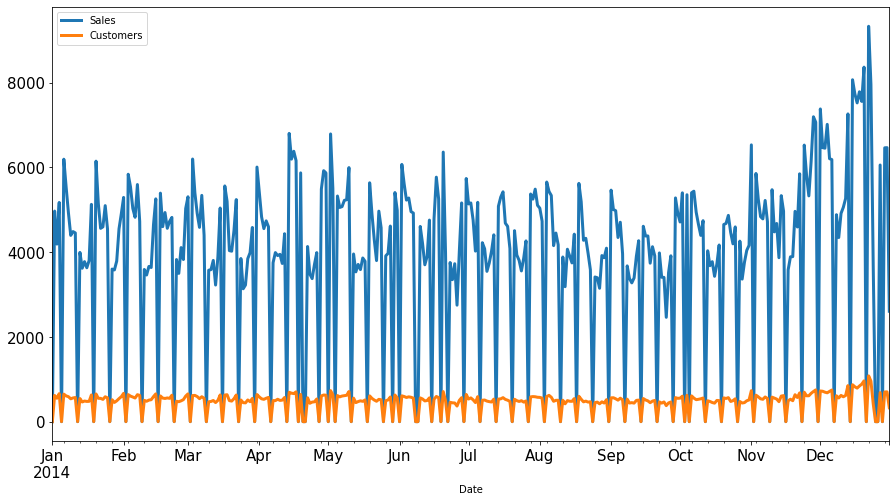

In [30]:
#  Multivariate Plot Overlay : Sales and Customer

df_2014 = df_store_1["2014"]

customer_df_2014 = df_2014[["Sales", "Customers"]]
customer_df_2014.plot(figsize=(15,8), linewidth=3, fontsize=15)

In [31]:
# df_2014

## 3. Feature Generation

In [32]:
# Extract Features From Date column

def create_features(df, label=None):
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    return df.drop(columns=["date"], axis="column")

In [33]:
df_store_1 = create_features(df_store_1)
df_store_1.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1,1,1,1,2013,1,1,1
2013-01-02,1,3,5530,668,1,0,0,1,2,1,1,2013,2,2,1
2013-01-03,1,4,4327,578,1,0,0,1,3,1,1,2013,3,3,1
2013-01-04,1,5,4486,619,1,0,0,1,4,1,1,2013,4,4,1
2013-01-05,1,6,4997,635,1,0,0,1,5,1,1,2013,5,5,1


In [34]:
# Select important cols
print(df_store_1.columns)

# We only have One Store = 1
df_store_1 = df_store_1.drop("Store", axis=1)


Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')


In [35]:
# Creating Lag features

df_store_1["Lag_1"] = df_store_1["Sales"].shift(1)
df_store_1["Lag_2"] = df_store_1["Sales"].shift(2)
df_store_1["Lag_3"] = df_store_1["Sales"].shift(3)
df_store_1["Lag_4"] = df_store_1["Sales"].shift(4)
df_store_1["Lag_5"] = df_store_1["Sales"].shift(5)
df_store_1["Lag_6"] = df_store_1["Sales"].shift(6)
df_store_1["Lag_7"] = df_store_1["Sales"].shift(7)
df_store_1["Lag_8"] = df_store_1["Sales"].shift(8)

df_store_1 = df_store_1.dropna()

df_store_1.head()

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,dayofweek,quarter,month,...,dayofmonth,weekofyear,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-09,3,5471,626,1,1,0,1,2,1,1,...,9,2,5580.0,7176.0,0.0,4997.0,4486.0,4327.0,5530.0,0.0
2013-01-10,4,4892,615,1,1,0,1,3,1,1,...,10,2,5471.0,5580.0,7176.0,0.0,4997.0,4486.0,4327.0,5530.0
2013-01-11,5,4881,592,1,1,0,1,4,1,1,...,11,2,4892.0,5471.0,5580.0,7176.0,0.0,4997.0,4486.0,4327.0
2013-01-12,6,4952,646,1,0,0,0,5,1,1,...,12,2,4881.0,4892.0,5471.0,5580.0,7176.0,0.0,4997.0,4486.0
2013-01-13,7,0,0,0,0,0,0,6,1,1,...,13,2,4952.0,4881.0,4892.0,5471.0,5580.0,7176.0,0.0,4997.0


In [36]:
# Correlation between Features Check

import matplotlib.pyplot as plt

corr = df_store_1.corr()
corr.style.background_gradient(cmap='coolwarm')



,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8
DayOfWeek,1.000000,-0.503285,-0.497939,-0.547689,-0.391406,-0.067250,1.000000,-0.009374,-0.007241,0.000701,-0.006824,0.004710,-0.005380,0.474988,0.225757,0.086545,0.050252,-0.075125,-0.257436,-0.504009,0.475095
Sales,-0.503285,1.000000,0.984323,0.888965,0.470992,0.007304,-0.503285,0.039617,0.047053,-0.065937,0.044754,-0.027923,0.044143,-0.124279,-0.033652,0.064765,0.000363,-0.115769,-0.227900,0.633945,-0.242484
Customers,-0.497939,0.984323,1.000000,0.927770,0.377572,-0.001888,-0.497939,0.012921,0.019765,-0.086678,0.018365,-0.020242,0.019417,-0.133589,-0.057624,0.047844,-0.006276,-0.104310,-0.234615,0.689539,-0.203716
Open,-0.547689,0.888965,0.927770,1.000000,0.298497,0.003528,-0.547689,0.004314,-0.001983,-0.006272,0.000286,0.023301,0.002330,-0.170035,-0.167320,-0.043771,-0.081248,-0.156951,-0.226230,0.709436,-0.169998
Promo,-0.391406,0.470992,0.377572,0.298497,1.000000,0.033650,-0.391406,-0.008185,-0.013574,0.021817,-0.023940,-0.118732,-0.000977,0.099295,0.121025,0.058515,-0.077411,-0.222355,0.095679,0.024534,-0.313558
SchoolHoliday,-0.067250,0.007304,-0.001888,0.003528,0.033650,1.000000,-0.067250,0.196356,0.134846,-0.074734,0.137075,0.035084,0.099770,-0.043671,-0.022565,-0.027739,-0.016697,-0.010492,0.064786,0.073857,0.029215
dayofweek,1.000000,-0.503285,-0.497939,-0.547689,-0.391406,-0.067250,1.000000,-0.009374,-0.007241,0.000701,-0.006824,0.004710,-0.005380,0.474988,0.225757,0.086545,0.050252,-0.075125,-0.257436,-0.504009,0.475095
quarter,-0.009374,0.039617,0.012921,0.004314,-0.008185,0.196356,-0.009374,1.000000,0.968962,-0.261719,0.965873,0.000814,0.939669,0.042966,0.031268,0.029155,0.033901,0.027013,0.040048,0.050333,0.050264
month,-0.007241,0.047053,0.019765,-0.001983,-0.013574,0.134846,-0.007241,0.968962,1.000000,-0.273703,0.996263,-0.003859,0.964772,0.052856,0.042728,0.047067,0.050945,0.040478,0.053677,0.063407,0.066315
year,0.000701,-0.065937,-0.086678,-0.006272,0.021817,-0.074734,0.000701,-0.261719,-0.273703,1.000000,-0.274610,-0.014466,-0.262305,-0.069986,-0.068650,-0.067864,-0.070884,-0.070002,-0.072688,-0.079423,-0.077468


## 4. Data Spliting

In [37]:
# Not Important col
df_store_1 = df_store_1.drop("StateHoliday", axis=1)


In [38]:
### 2013:2014 data is Train data
train = df_store_1["2013":"2014"]
train = train.reset_index()

## 2015 data is Test data
test = df_store_1["2015"]
test = test.reset_index()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



In [39]:
display(train.head())
display(test.head())

,Date,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,dayofweek,quarter,month,...,dayofmonth,weekofyear,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8
0,2013-01-09,3,5471,626,1,1,1,2,1,1,...,9,2,5580.0,7176.0,0.0,4997.0,4486.0,4327.0,5530.0,0.0
1,2013-01-10,4,4892,615,1,1,1,3,1,1,...,10,2,5471.0,5580.0,7176.0,0.0,4997.0,4486.0,4327.0,5530.0
2,2013-01-11,5,4881,592,1,1,1,4,1,1,...,11,2,4892.0,5471.0,5580.0,7176.0,0.0,4997.0,4486.0,4327.0
3,2013-01-12,6,4952,646,1,0,0,5,1,1,...,12,2,4881.0,4892.0,5471.0,5580.0,7176.0,0.0,4997.0,4486.0
4,2013-01-13,7,0,0,0,0,0,6,1,1,...,13,2,4952.0,4881.0,4892.0,5471.0,5580.0,7176.0,0.0,4997.0


,Date,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,dayofweek,quarter,month,...,dayofmonth,weekofyear,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8
0,2015-01-01,4,0,0,0,0,1,3,1,1,...,1,1,2605.0,6466.0,6463.0,0.0,6057.0,0.0,0.0,3659.0
1,2015-01-02,5,5509,657,1,0,1,4,1,1,...,2,1,0.0,2605.0,6466.0,6463.0,0.0,6057.0,0.0,0.0
2,2015-01-03,6,5023,645,1,0,1,5,1,1,...,3,1,5509.0,0.0,2605.0,6466.0,6463.0,0.0,6057.0,0.0
3,2015-01-04,7,0,0,0,0,1,6,1,1,...,4,1,5023.0,5509.0,0.0,2605.0,6466.0,6463.0,0.0,6057.0
4,2015-01-05,1,6239,712,1,1,1,0,1,1,...,5,2,0.0,5023.0,5509.0,0.0,2605.0,6466.0,6463.0,0.0


## 5. Time-Series Modeling

> SNARIMAX stands for (S)easonal (N)on-linear (A)uto(R)egressive (I)ntegrated (M)oving-(A)verage with e(X)ogenous inputs model.

https://riverml.xyz/0.14.0/introduction/basic-concepts/

In [40]:
print(dir(river))

['__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_bandit', 'anomaly', 'base', 'cluster', 'compat', 'compose', 'datasets', 'drift', 'dummy', 'ensemble', 'evaluate', 'facto', 'feature_extraction', 'feature_selection', 'imblearn', 'linear_model', 'metrics', 'misc', 'model_selection', 'multiclass', 'multioutput', 'naive_bayes', 'neighbors', 'neural_net', 'optim', 'preprocessing', 'proba', 'reco', 'rules', 'stats', 'stream', 'synth', 'time_series', 'tree', 'utils']


In [41]:
print(dir(river.time_series))

['Forecaster', 'ForecastingMetric', 'HoltWinters', 'HorizonMetric', 'SNARIMAX', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'base', 'evaluate', 'holt_winters', 'metrics', 'snarimax']


p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

## 5.1 Search Params: p q d m

In [42]:
# Grid Search
import pmdarima as pm

model = pm.auto_arima(df_store_1["Sales"],
                     m=7,
                     seasonal=True,
                     start_p=0,
                     start_q=0,
                     max_order=8,
                     test="adf",
                     error_action="ignore",
                     suppress_warmnings=True,
                      stepwise=True, trace=True
                     )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=5.95 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=16862.505, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=16737.190, Time=0.82 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=16649.479, Time=1.57 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=18335.635, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=16849.261, Time=0.10 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=16630.416, Time=3.52 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=16799.781, Time=0.88 sec
 ARIMA(0,0,1)(2,0,1)[7] intercept   : AIC=inf, Time=6.95 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=16428.188, Time=5.93 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=16432.449, Time=2.87 sec
 ARIMA(0,0,1)(2,0,2)[7] intercept   : AIC=16358.256, Time=8.05 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=8.00 sec
 ARIMA(1,0,1)(2,0,2)[7] intercept   : AIC=inf, Time=8.94 sec
 ARIMA(0,0,2)(2,0,2)[7] intercept   : AIC=1

KeyboardInterrupt: 

Best model:  ARIMA(0,0,1)(2,0,2)[7] intercept
Total fit time: 92.987 seconds


In [ ]:
# model.summary()

## 5.2 Online Learning:
    - We have two mode to learn:
        1. Batch Train -> Predict test -> End
        2. Batch Train -> Predict One test -> Learn One test -> End

###  1. Batch Train -> Predict test


Above we see : Best model:  ARIMA(0,0,1)(2,0,2)[7] intercept


In [43]:
# Build Model
model = river.time_series.SNARIMAX(p=0, d=0, q=1, m=7, sp=2, sd=0, sq=2)

## Only Train
# for a in train.iterrows():
#     model.learn_one(a[1]["Sales"])
    

# # Forecast for All days
# forecast = model.forecast(horizon=len(test))

# test_new = test.copy()
# test_new["sales_batch_pred"] = forecast

In [44]:
# Only Train
# for a,b in enumerate(train.iterrows()):
#     model.learn_one(b[1][-1])

for a in train.iterrows():
    model.learn_one(a[1]["Sales"])

In [45]:
# f = []
# future = []
# for a in test.iterrows():
#     x = a[1]["Date"].date()
#     f.append(x)
#     dd = {"Date" : x}
#     future.append(dd)
    
# # print(f)
# # print(future)

In [46]:
# Forecast for All days
forecast = model.forecast(horizon=len(test))

In [47]:
test_new = test.copy()
# print(len(test))
test_new["sales_batch_pred"] = forecast

<AxesSubplot:xlabel='Date'>

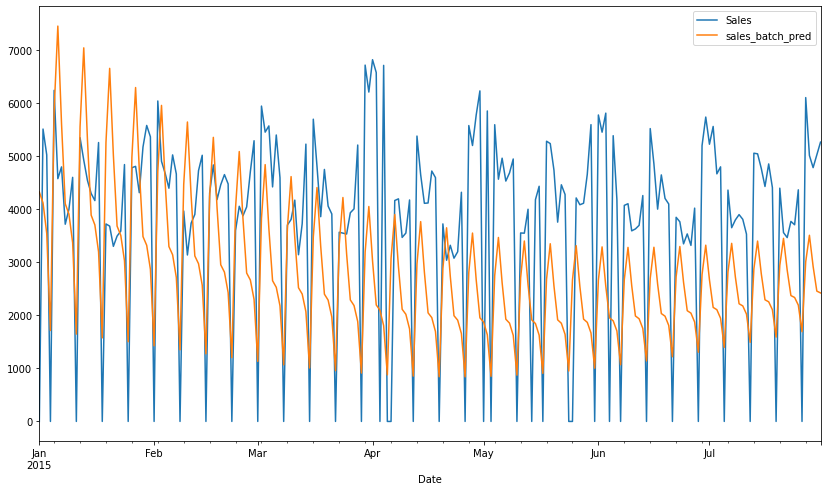

In [48]:
test_idx = test_new[["Date", "Sales", "sales_batch_pred"]].set_index("Date")
test_idx.plot()

In [49]:
model._get_params()

{'p': 0,
 'd': 0,
 'q': 1,
 'm': 7,
 'sp': 2,
 'sd': 0,
 'sq': 2,
 'regressor': (river.compose.pipeline.Pipeline,
  {'StandardScaler': {'with_std': True},
   'LinearRegression': {'optimizer': (river.optim.sgd.SGD,
     {'lr': (river.optim.schedulers.Constant, {'learning_rate': 0.01})}),
    'loss': (river.optim.losses.Squared, {}),
    'l2': 0.0,
    'intercept_init': 0.0,
    'intercept_lr': (river.optim.schedulers.Constant, {'learning_rate': 0.01}),
    'clip_gradient': 1000000000000.0,
    'initializer': (river.optim.initializers.Zeros, {})}})}


### 2. Batch learn -> Predict One test -> Learn One test

Above we see : Best model:  ARIMA(0,0,1)(2,0,2)[7] intercept


In [50]:
# Build Model
model = river.time_series.SNARIMAX(p=0,d=0,q=1, m=7,sp=2, sd=0, sq=2)

# Learn-one at a time, Batch size = 1
# for a,b in enumerate(train.iterrows()):
#     model.learn_one(b[1][-1])

# Training
for a in train.iterrows():
    model.learn_one(a[1]["Sales"])

# Predict -> Learn
forecast_train = []

for a in test.iterrows():
    
    # Predict only 1 future value:
    single = model.forecast(horizon=1)
    forecast_train.append(single[0])
    
    # Learn from one test data:
    model.learn_one(a[1]["Sales"])
    
    
test_new["sales_pred_train"] = forecast_train



In [51]:
model._get_params()

{'p': 0,
 'd': 0,
 'q': 1,
 'm': 7,
 'sp': 2,
 'sd': 0,
 'sq': 2,
 'regressor': (river.compose.pipeline.Pipeline,
  {'StandardScaler': {'with_std': True},
   'LinearRegression': {'optimizer': (river.optim.sgd.SGD,
     {'lr': (river.optim.schedulers.Constant, {'learning_rate': 0.01})}),
    'loss': (river.optim.losses.Squared, {}),
    'l2': 0.0,
    'intercept_init': 0.0,
    'intercept_lr': (river.optim.schedulers.Constant, {'learning_rate': 0.01}),
    'clip_gradient': 1000000000000.0,
    'initializer': (river.optim.initializers.Zeros, {})}})}

In [ ]:
# forecast_train = []

# for a in test.iterrows():
    
#     # Predict only 1 future value:
#     single = model.forecast(horizon=1)
#     forecast_train.append(single[0])
    
#     # Learn from one test data:
#     model.learn_one(a[1]["Sales"])


In [ ]:
# test_new["sales_pred_train"] = forecast_train

<AxesSubplot:xlabel='Date'>

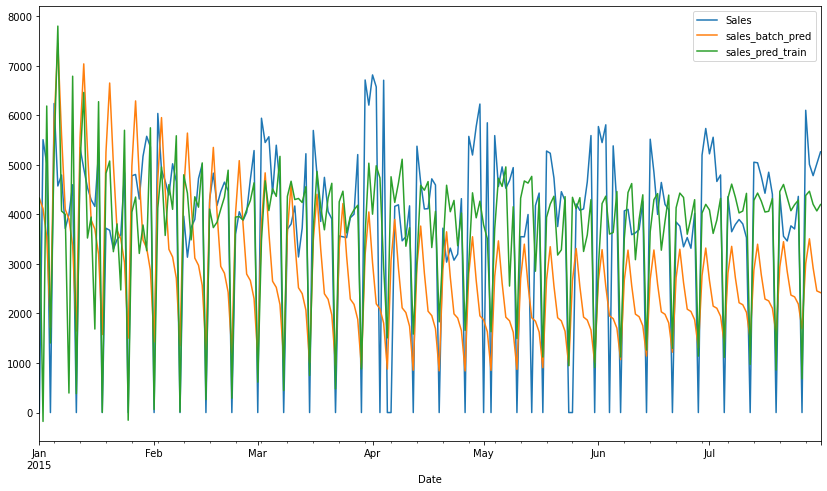

In [52]:
test_idx = test_new[["Date", "Sales", "sales_batch_pred", "sales_pred_train"]].set_index("Date")

# test_idx = test_new[["Date", "Sales", "sales_pred_train"]].set_index("Date")

test_idx.plot()

<AxesSubplot:xlabel='Date'>

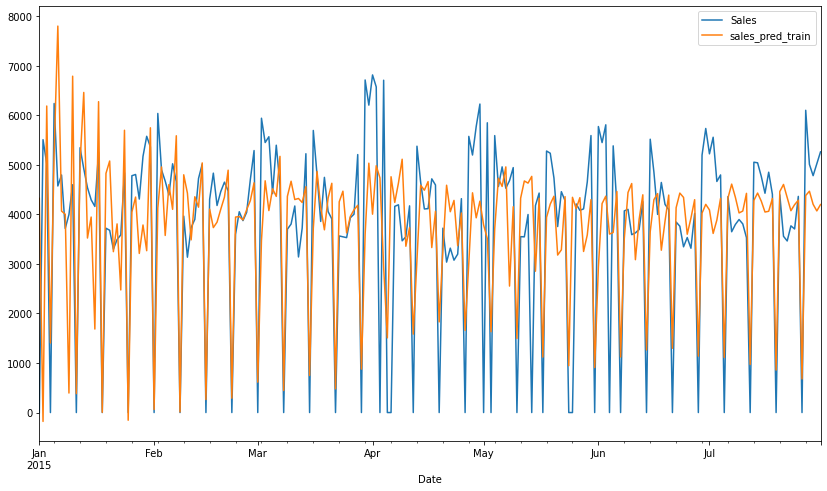

In [53]:
only_online = test_new[["Date", "Sales","sales_pred_train"]].set_index("Date")

# test_idx = test_new[["Date", "Sales", "sales_pred_train"]].set_index("Date")

only_online.plot()

In [54]:

import plotly.graph_objects as go

fig_1 = px.line(test_idx.reset_index(), x=test_idx.reset_index().Date, y='Sales', title='Store 1: Sales with Slider')
fig_1.update_traces(line=dict(color = 'blue'))

fig_2 = px.line(test_idx.reset_index(), x=test_idx.reset_index().Date, y='sales_batch_pred')
fig_2.update_traces(line=dict(color = 'red'))

fig_3 = px.line(test_idx.reset_index(), x=test_idx.reset_index().Date, y='sales_pred_train')
fig_3.update_traces(line=dict(color = 'orange'))


# fig_4 = go.Figure(data=fig_1.data + fig_2.data + fig_3.data)
fig_4 = go.Figure(data=fig_1.data + fig_3.data)


fig_4.update_xaxes(rangeslider_visible=True)

fig_4.show()

In [55]:
# Exclude Store closed day
test_no_zero = test_idx.query("Sales != 0")

print(f"sales_pred_train RMSE : {np.sqrt(mse(test_no_zero.Sales, test_no_zero.sales_pred_train))}")

print(f"sales_batch_pred RMSE : {np.sqrt(mse(test_idx.Sales, test_idx.sales_batch_pred))}")


sales_pred_train RMSE : 1222.620264578084
sales_batch_pred RMSE : 1953.219823462


### Group sales by month

<AxesSubplot:xlabel='Date'>

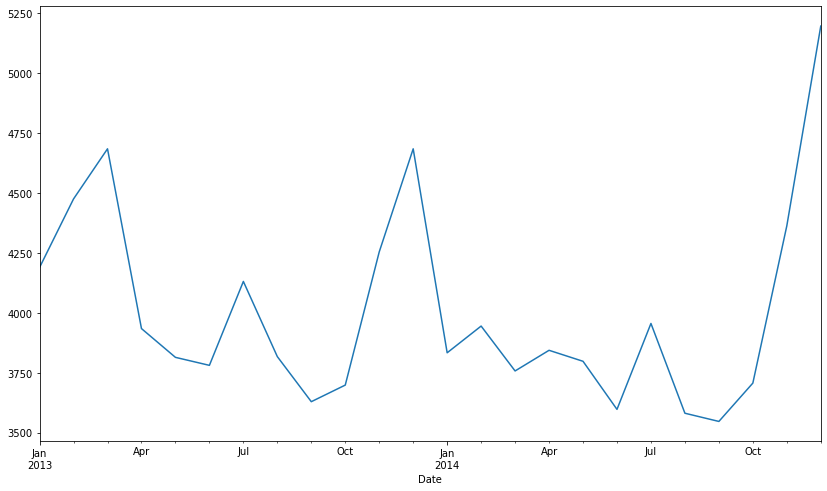

In [64]:
# train_resampled = train.set_index("Date")
# train_resampled = train_resampled.resample("M").mean()

# train_resampled["Sales"].plot()

In [65]:
# train_resampled.describe()

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,dayofweek,quarter,month,year,...,dayofmonth,weekofyear,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.00000,24.000000,24.000000,...,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,3.998188,4008.277240,476.536313,0.831630,0.377678,0.216098,2.998188,2.50000,6.500000,2013.500000,...,15.875000,26.347225,4012.646818,4014.679869,4003.993951,4011.329917,4011.266486,4016.273420,4023.638272,4016.355417
std,0.119519,415.322703,46.148395,0.035243,0.049256,0.272597,0.119519,1.14208,3.526299,0.510754,...,0.980794,14.771779,437.642648,420.857791,442.790285,446.973757,425.164591,457.022628,491.600505,487.828817
min,3.806452,3546.600000,414.733333,0.741935,0.322581,0.000000,2.806452,1.00000,1.000000,2013.000000,...,14.500000,3.000000,3382.633333,3343.100000,3472.066667,3472.266667,3459.933333,3491.066667,3491.366667,3377.800000
25%,3.903226,3744.338710,450.443548,0.806452,0.333333,0.000000,2.903226,1.75000,3.750000,2013.000000,...,15.500000,14.604839,3734.801613,3787.772849,3741.991935,3752.676613,3759.395161,3750.863441,3748.620968,3762.260753
50%,4.000000,3837.888172,458.145161,0.838710,0.361905,0.145863,3.000000,2.50000,6.500000,2013.500000,...,16.000000,26.620968,3836.736559,3849.451613,3877.937634,3870.423656,3881.797312,3872.419355,3876.733333,3912.127957
75%,4.096774,4204.658696,500.500000,0.859524,0.404839,0.338710,3.096774,3.25000,9.250000,2014.000000,...,16.000000,38.717742,4188.036957,4178.426087,4116.011957,4094.950000,4055.579839,3995.991935,4065.100000,4028.116667
max,4.193548,5194.387097,585.806452,0.870968,0.500000,1.000000,3.193548,4.00000,12.000000,2014.000000,...,20.000000,47.225806,5110.354839,5129.709677,5153.322581,5351.516129,5328.000000,5515.580645,5726.129032,5608.096774


<AxesSubplot:xlabel='Date'>

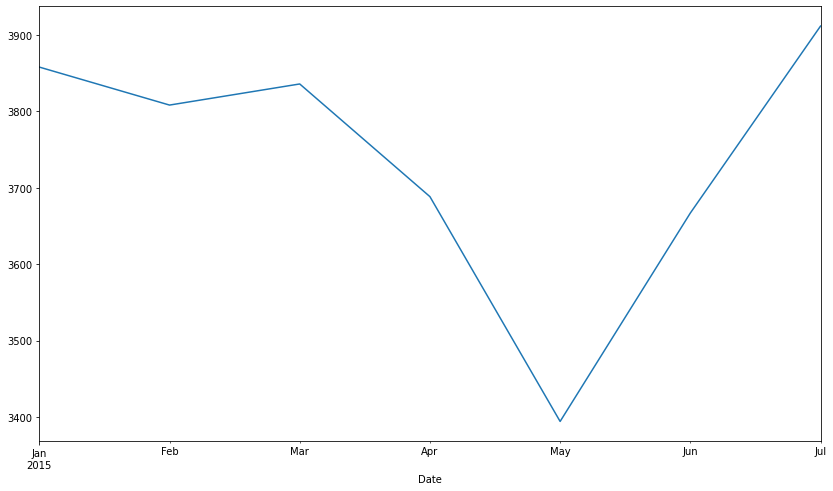

In [66]:
# test_resampled = test.set_index("Date")
# test_resampled = test_resampled.resample("M").mean()

# test_resampled["Sales"].plot()

In [96]:
# test_resampled.describe()

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,dayofweek,quarter,month,year,...,dayofmonth,weekofyear,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.0,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,4.003687,3737.726783,438.657702,0.825828,0.400329,0.121352,3.003687,1.714286,4.000000,2015.0,...,15.642857,15.989269,3724.630140,3731.927716,3740.148288,3717.228659,3718.125455,3718.754411,3698.180985,3697.639083
std,0.115313,175.543924,28.611962,0.043034,0.043686,0.142882,0.115313,0.755929,2.160247,0.0,...,0.556349,9.328606,151.179469,148.998725,135.876350,120.827204,127.952774,146.972988,131.537975,165.571167
min,3.833333,3394.193548,388.774194,0.741935,0.354839,0.000000,2.833333,1.000000,1.000000,2015.0,...,14.500000,3.129032,3475.866667,3489.033333,3545.766667,3533.533333,3534.032258,3537.483871,3583.900000,3458.500000
25%,3.951075,3677.766667,422.950000,0.816667,0.372120,0.000000,2.951075,1.000000,2.500000,2015.0,...,15.500000,9.468894,3641.431720,3660.033333,3631.374731,3656.520968,3661.839247,3620.389785,3613.629032,3614.741398
50%,4.000000,3808.392857,452.000000,0.838710,0.400000,0.064516,3.000000,2.000000,4.000000,2015.0,...,16.000000,15.933333,3769.161290,3741.741935,3778.483871,3700.483871,3672.833333,3695.433333,3665.266667,3735.967742
75%,4.048387,3847.080645,457.497120,0.847926,0.409677,0.225806,3.048387,2.000000,5.500000,2015.0,...,16.000000,22.462366,3808.743664,3819.955069,3855.822581,3787.806452,3785.774194,3795.274194,3721.903226,3739.725806
max,4.193548,3911.806452,468.935484,0.870968,0.483871,0.333333,3.193548,3.000000,7.000000,2015.0,...,16.000000,29.000000,3927.032258,3932.741935,3882.392857,3897.928571,3924.785714,3967.035714,3967.035714,3980.071429


In [97]:
# fig_1 = px.line(train_resampled, x=range(0,len(train_resampled.reset_index().Date)), y='Sales')
# fig_1.update_traces(line=dict(color = 'orange'))


# fig_2 = px.line(test_resampled, x=range(0,len(test_resampled.reset_index().Date)), y='Sales')
# fig_2.update_traces(line=dict(color = 'blue'))

# fig_4 = go.Figure(data=fig_1.data + fig_2.data)

# fig_4.update_xaxes(rangeslider_visible=True)

# fig_4.show()

## 5.3 XGBOOST

<b>Idea: Train and Save on the first batch. On Next run, pass saved model path to "xgb.train" method.

Algorithm:
 - Batch Train the model on Train (2013)
 - Test data divide into months chunk
 - Incremental Way:
     -for each month:
         - predict the month
         - error measure (yhat-y)
         - train on that month
 - Not learning:
     -for each month:
             - predict the month
             - error measure (yhat-y)

In [74]:
os.remove("/kaggle/working/model_1.model")
os.remove("/kaggle/working/model_1_re.model")
os.remove("/kaggle/working/model_1_re_month.model")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/model_1.model'

In [189]:
# train.drop("StateHoliday", axis=1, inplace=True)
# test.drop("StateHoliday", axis=1, inplace=True)

In [76]:
# Train-Val
X_train = train.set_index("Date")["2013-01":"2014-11"]
X_val = train.set_index("Date")["2014-12"]

y_train = train.set_index("Date")["2013-01":"2014-11"][["Sales"]]
y_val = train.set_index("Date")["2014-12"][["Sales"]]



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



In [77]:
X_train = X_train.drop("Sales", axis=1)
X_val = X_val.drop("Sales", axis=1)


In [78]:

xg_train = xgb.DMatrix(X_train, label=y_train)
xg_val = xgb.DMatrix(X_val, label=y_val)

In [79]:
# 1 . Batch Train the model on Train (2013)


params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'max_depth' : 1000}
model_1 = xgb.train(params,
                    xg_train,
                    num_boost_round=1000,
                    evals=[(xg_val, 'validation')],
                    early_stopping_rounds=50 
                   )

# Model save
model_1.save_model('model_1.model') # No re-learning
model_1.save_model('model_1_re.model') # pred->learning 
model_1.save_model('model_1_re_month.model') # month based retraining->prediction

model_2 = copy.deepcopy(model_1)
model_3 = copy.deepcopy(model_1)

[0]	validation-rmse:4360.44447
[1]	validation-rmse:3239.84100
[2]	validation-rmse:2439.76987
[3]	validation-rmse:1829.32828
[4]	validation-rmse:1470.02818
[5]	validation-rmse:1161.95437
[6]	validation-rmse:1024.81202
[7]	validation-rmse:897.47236
[8]	validation-rmse:794.57407
[9]	validation-rmse:723.19528
[10]	validation-rmse:663.67604
[11]	validation-rmse:630.38179
[12]	validation-rmse:617.68174
[13]	validation-rmse:602.18614
[14]	validation-rmse:594.89836
[15]	validation-rmse:583.93196
[16]	validation-rmse:574.64147
[17]	validation-rmse:565.00122
[18]	validation-rmse:560.85960
[19]	validation-rmse:557.67034
[20]	validation-rmse:556.02623
[21]	validation-rmse:553.30051
[22]	validation-rmse:551.06068
[23]	validation-rmse:549.14098
[24]	validation-rmse:547.82671
[25]	validation-rmse:546.74135
[26]	validation-rmse:545.96319
[27]	validation-rmse:546.11814
[28]	validation-rmse:545.62409
[29]	validation-rmse:545.32691
[30]	validation-rmse:544.76468
[31]	validation-rmse:544.29382
[32]	valida

In [80]:
test

,Date,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,dayofweek,quarter,month,...,dayofmonth,weekofyear,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8
0,2015-01-01,4,0,0,0,0,1,3,1,1,...,1,1,2605.0,6466.0,6463.0,0.0,6057.0,0.0,0.0,3659.0
1,2015-01-02,5,5509,657,1,0,1,4,1,1,...,2,1,0.0,2605.0,6466.0,6463.0,0.0,6057.0,0.0,0.0
2,2015-01-03,6,5023,645,1,0,1,5,1,1,...,3,1,5509.0,0.0,2605.0,6466.0,6463.0,0.0,6057.0,0.0
3,2015-01-04,7,0,0,0,0,1,6,1,1,...,4,1,5023.0,5509.0,0.0,2605.0,6466.0,6463.0,0.0,6057.0
4,2015-01-05,1,6239,712,1,1,1,0,1,1,...,5,2,0.0,5023.0,5509.0,0.0,2605.0,6466.0,6463.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,2015-07-27,1,6102,612,1,1,1,0,3,7,...,27,31,0.0,4364.0,3706.0,3769.0,3464.0,3558.0,4395.0,0.0
208,2015-07-28,2,5011,560,1,1,1,1,3,7,...,28,31,6102.0,0.0,4364.0,3706.0,3769.0,3464.0,3558.0,4395.0
209,2015-07-29,3,4782,523,1,1,1,2,3,7,...,29,31,5011.0,6102.0,0.0,4364.0,3706.0,3769.0,3464.0,3558.0
210,2015-07-30,4,5020,546,1,1,1,3,3,7,...,30,31,4782.0,5011.0,6102.0,0.0,4364.0,3706.0,3769.0,3464.0


###  Pred - Retrain Model: 

In [81]:

# Retrain Model

test_train = test.copy()

test_train = test_train.set_index("Date")
# yr = "2014"
# month = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

yr = "2015"
month = ["01", "02", "03", "04", "05", "06", "07"]

errors = []

for m in month:
    # 1 month Data
    df = test_train[yr+"-"+m]
    x_test = df.drop("Sales", axis=1)
    y_test = df[["Sales"]]
    
    xg_test = xgb.DMatrix(x_test, label=y_test)
    
    # Error 
#     mae_ = mae(model_1.predict(xg_test), y_test)
    rmse = np.sqrt(mse(model_1.predict(xg_test), y_test))
    
#     errors.append(rmse)
    
    if len(errors) <= 0:
        print(f"First Iteraion, Rmse : {rmse} => Retrain")
        model_1 = xgb.train(params,
                            xg_test,
                            num_boost_round=1000,
                            xgb_model='model_1_re.model')
        # Save the updated model
        model_1.save_model('model_1_re.model')
    
    elif errors[-1] <= rmse: # If the prev retrain works, Means retraining working
        print(f"{errors[-1]} <= {rmse} => Retrain")
        # Train on the Unseen data
        model_1 = xgb.train(params,
                            xg_test,
                            num_boost_round=1000,
                            xgb_model='model_1_re.model')
        # Save the updated model
        model_1.save_model('model_1_re.model')
        
    else:
        print(f"{errors[-1]} < {rmse} => No retrain")
        # Train on the Unseen data
#         model_1 = xgb.train(params,
#                             xg_test,
#                             num_boost_round=1000)
    
        
    
    errors.append(rmse)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



First Iteraion, Rmse : 233.57447482566752 => Retrain


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



233.57447482566752 <= 302.4462868772506 => Retrain


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



302.4462868772506 <= 443.1753962132905 => Retrain


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



443.1753962132905 <= 483.2291696823515 => Retrain


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



483.2291696823515 < 405.8030584193343 => No retrain
405.8030584193343 <= 450.33905183037234 => Retrain


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



450.33905183037234 <= 701.6574519421555 => Retrain


### Only predict, no retrain

In [82]:
# No Retrain : Model_2

test_train = test.copy()

test_train = test_train.set_index("Date")
# yr = "2014"
# month = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

yr = "2015"
month = ["01", "02", "03", "04", "05", "06", "07"]

errors_batch = []

for m in month:
    df = test_train[yr+"-"+m]
    
    x_test = df.drop("Sales", axis=1)
    y_test = df[["Sales"]]
    
    xg_test = xgb.DMatrix(x_test, label=y_test)
    
#     mae_ = mae(model_2.predict(xg_test), y_test)
#     errors_batch.append(mae_)
    rmse = np.sqrt(mse(model_2.predict(xg_test), y_test))
    errors_batch.append(rmse)
    print(f"Rmse {rmse}")
#     print(f"Month {m}, Mae: {mae_}")
    
#     model_2 = xgb.train(params, xg_train_df, 300) #, xgb_model='model_1.model')
#     model_1.save_model('model_1.model')
    

Rmse 233.57447482566752
Rmse 251.62852611880513
Rmse 275.4381897629424
Rmse 298.0247154412358
Rmse 295.45472390973225
Rmse 256.9080001913624
Rmse 229.46981427087746


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice t

### Retrain based on same Month

In [198]:
# Retrain monthly

train_cpy = train.copy()
train_cpy = train_cpy.set_index("Date")
test_cpy = test.copy()
test_cpy = test_cpy.set_index("Date")


yr_train = "2013"
yr_test = "2014"
month = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

errors_re_monthly = []

for m in month:
    # 1 month Data
    df_train = train_cpy[yr_train + "-" + m]
    df = test_cpy[yr + "-" + m]
    
    x_train = df_train.drop("Sales", axis=1)
    y_train = df_train[["Sales"]]
    
    x_test = df.drop("Sales", axis=1)
    y_test = df[["Sales"]]
    
    xg_train = xgb.DMatrix(x_train, label=y_train)
    xg_test = xgb.DMatrix(x_test, label=y_test)
    
    
    model_3 = xgb.train(params,
                        xg_train,
                        num_boost_round=1000)
#                             xgb_model='model_1_re_month.model')
    
    # Error 
    rmse = np.sqrt(mse(model_3.predict(xg_test), y_test))    
        
    
    errors_re_monthly.append(rmse)
    model_3.save_model("model_1_re_month.model")
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice t

In [83]:
# err_df = pd.DataFrame({"Online_err":errors, "Batch_err":errors_batch, "monthly_based_training":errors_re_monthly})

err_df = pd.DataFrame({"Online_err":errors, "Batch_err":errors_batch})

err_df

,Online_err,Batch_err
0,233.574475,233.574475
1,302.446287,251.628526
2,443.175396,275.438190
3,483.229170,298.024715
4,405.803058,295.454724
5,450.339052,256.908000
6,701.657452,229.469814


<AxesSubplot:>

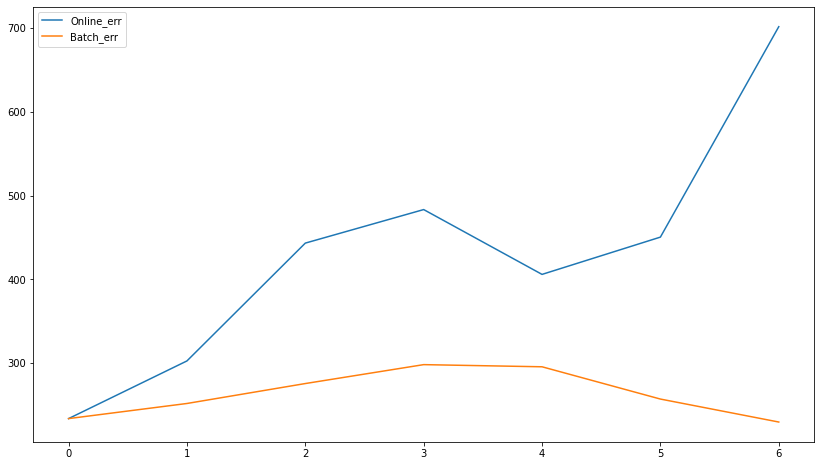

In [84]:
err_df.plot()

In [ ]:
First Iteraion, Rmse : 240.26821289637468
240.26821289637468 <= 332.5751504078399 => Retrain
332.5751504078399 < 291.99563802960813 => No retrain
291.99563802960813 <= 418.606015089084 => Retrain
418.606015089084 < 339.52815886979386 => No retrain
339.52815886979386 <= 487.00287293229786 => Retrain
487.00287293229786 < 381.3792266516703 => No retrain
381.3792266516703 <= 396.2939201794946 => Retrain
396.2939201794946 <= 440.1687762663778 => Retrain
440.1687762663778 <= 700.9055219305193 => Retrain
700.9055219305193 < 634.6346143269408 => No retrain
634.6346143269408 <= 1554.7379526945297 => Retrain


In [ ]:
#TEST
# xgb.train()
# test_train
# df
# import os
# model_2.best_iteration
os.remove("/kaggle/working/model_1.model")

## **half Space trees**

In [ ]:
from skmultiflow.data import AnomalySineGenerator
from skmultiflow.anomaly_detection import HalfSpaceTrees

# Setup a data stream
stream = AnomalySineGenerator(random_state=1, n_samples=1000, n_anomalies=250)

stream

In [ ]:
# Setup Half-Space Trees estimator
half_space_trees = HalfSpaceTrees(random_state=1)
# Setup variables to control loop and track performance
max_samples = 1000
n_samples = 0
true_positives = 0
detected_anomalies = 0
# Train the estimator(s) with the samples provided by the data stream
while n_samples < max_samples and stream.has_more_samples():
    X, y = stream.next_sample()
    y_pred = half_space_trees.predict(X)
    if y[0] == 1:
        true_positives += 1
        if y_pred[0] == 1:
            detected_anomalies += 1
    half_space_trees.partial_fit(X, y)
    n_samples += 1
print('{} samples analyzed.'.format(n_samples))
print('Half-Space Trees correctly detected {} out of {} anomalies'.
      format(detected_anomalies, true_positives))